# Image Classification With Neural Networks

## Chest X-ray Images (Pneumonia)

In [1]:
#importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from keras import layers, models, regularizers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

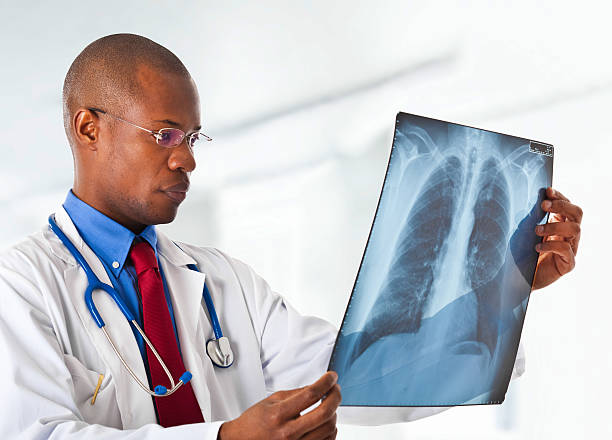

In [2]:
# Set the paths to train, test, and validation folders
train_folder = 'Data/train'
test_folder = 'Data/test'
val_folder = 'Data/val'


In [3]:
# Downsampling the images to 128X128 pixels
downsampled_size = (128, 128)

# Rescale pixel values between 0 and 1
datagen = ImageDataGenerator(rescale=1./255)  

# Load the train data
train_generator = datagen.flow_from_directory(
    train_folder,
    target_size=downsampled_size,
    batch_size=5216,
    class_mode='binary',
    shuffle=True
)

# Load the test data
test_generator = datagen.flow_from_directory(
    test_folder,
    target_size=downsampled_size,
    batch_size=624,
    class_mode='binary',
    shuffle=False
)

# Load the validation data
val_generator = datagen.flow_from_directory(
    val_folder,
    target_size=downsampled_size,
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


*  This dataset is separated into three folders. The "train" folder contains 5,216 images, the "validation" folder has 624 images, and the "test" folder contains 16 images.
* Each folder consists of two classes. One class represents normal chest X-rays, and the other class represents chest X-rays with pneumonia.

In the next step, we will perform exploratory data analysis (EDA) to examine the class distribution.


## Explanatory Data Analysis

In [4]:
## Retrieve the dictionary of class indices from the train_generator
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())
# Print the list of class labels
print('Class labels: {}'.format(class_names))


Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


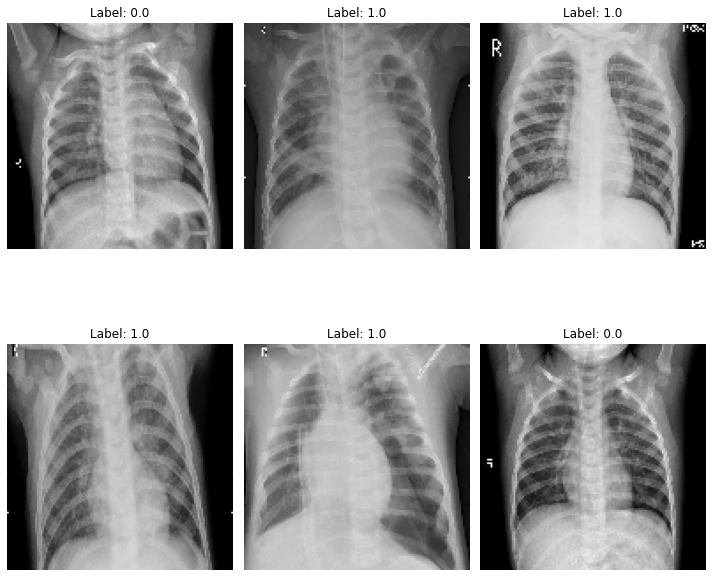

In [5]:
# Get a batch of images from the train generator
batch = next(train_generator)

# Extract the images and labels from the batch
images, labels = batch

# Display the first few images with their corresponding labels
num_images = 6

fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for i in range(num_images):
    axes[i//3, i%3].imshow(images[i], cmap='RdBu')
    axes[i//3, i%3].set_title('Label: {}'.format(labels[i]))
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

Class 0 represents chest X-ray images without pneumonia, while class 1 contains images with pneumonia. Differentiating between these two classes is challenging due to their visual similarity. Therefore, there is a need for a more accurate and effective model that can easily distinguish between them and improve pneumonia detection.

In [6]:
"""Function to visualization class distributions"""
def plot_class_counts(labels, title):
    # Get the counts for each class
    class_labels, counts = np.unique(labels, return_counts=True)
    # Calculate the percentage of value counts
    total_count = np.sum(counts)
    percentages = counts / total_count * 100
    # Plot the results
    plt.figure(figsize=(12,10))
    plt.title(f'{title}', fontsize='20')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    # Replace "1" with "Normal" in class_labels list
    class_labels = ['Pneumonia', 'Normal']
    # Add value counts as text on top of each bar
    for i in range(len(class_labels)):
        plt.text(i, counts[i], f"{counts[i]}\n{percentages[i]:.2f}%", ha='left', va='top')
    sns.barplot(x=class_labels, y=counts)
    plt.show()

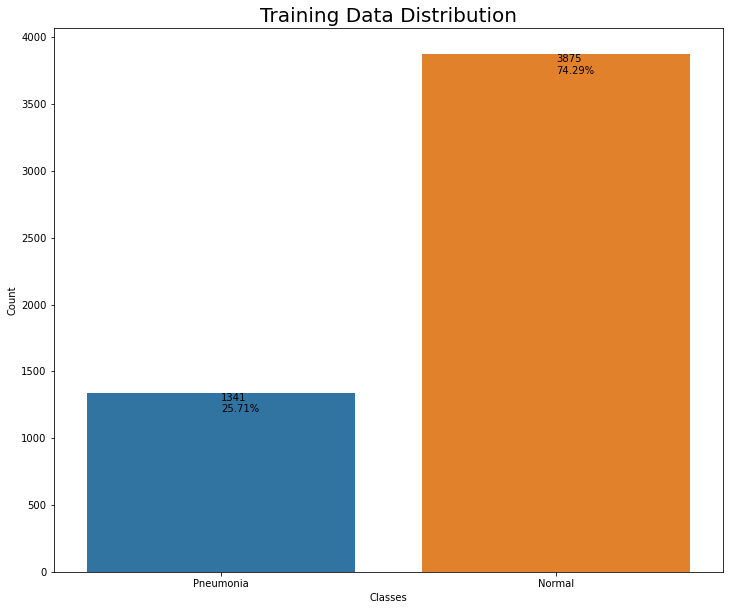

In [7]:
#training data distribution
labels = train_generator.classes
plot_class_counts(labels, 'Training Data Distribution')

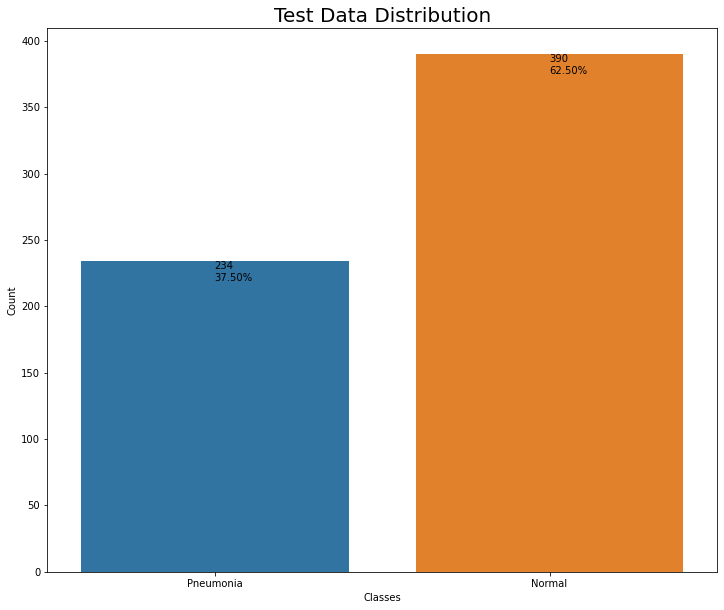

In [8]:
#test data distribution
test_labels = test_generator.classes
plot_class_counts(test_labels, 'Test Data Distribution')

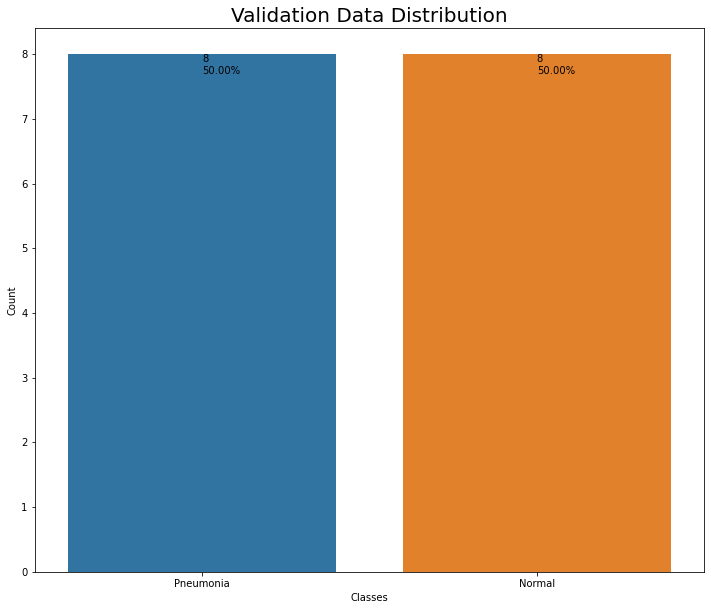

In [9]:
#validation data distribution
vals_labels = val_generator.classes
plot_class_counts(vals_labels, 'Validation Data Distribution')

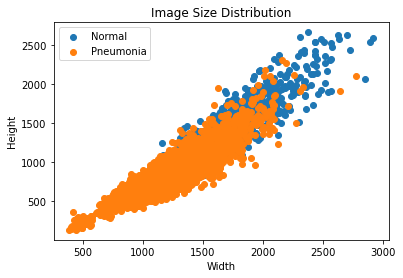

In [10]:
from PIL import Image
normal_image_sizes = []
pneumonia_image_sizes = []
for image_path in train_generator.filepaths:
    img = Image.open(image_path)
    width, height = img.size
    if "NORMAL" in image_path:
        normal_image_sizes.append((width, height))
    else:
        pneumonia_image_sizes.append((width, height))
normal_image_sizes = np.array(normal_image_sizes)
pneumonia_image_sizes = np.array(pneumonia_image_sizes)
plt.scatter(normal_image_sizes[:, 0], normal_image_sizes[:, 1], label='Normal')
plt.scatter(pneumonia_image_sizes[:, 0], pneumonia_image_sizes[:, 1], label='Pneumonia')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

## Data Preprocessing

Steps involved here are
* Obtaining images and labels from the train generator:The images and labels are returned as arrays. The train_images array contains the image data, and the train_labels array contains the corresponding labels.
* reshaping the image array.

In [11]:
# obtain images and labels from the test generator
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [12]:
# Explore the shape of the images and labels
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216,)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624,)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16,)


In [13]:
# Reshaping the images
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


# Modelling

# Baseline model : A Densely Connected Neural Network

In [14]:
# Build a baseline fully connected network

#intialize a sequential model
model_1 = models.Sequential()

#2 layers with relu activation
model_1.add(layers.Dense(64, activation='relu', input_shape=(49152,))) 
model_1.add(layers.Dense(32, activation='relu'))

#one layer with sigmoid activation
model_1.add(layers.Dense(1, activation='sigmoid'))

In [15]:
#compile the model
model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's inspect the shape of our model before training it and see how many training parameters we have.

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3145792   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,147,905
Trainable params: 3,147,905
Non-trainable params: 0
_________________________________________________________________


* 3,145,792 trainable parameters!

In [17]:
#train the model
results_1 = model_1.fit(train_img,
                    train_labels,
                    epochs=10,
                    batch_size=100,

                    validation_data=(val_img, val_labels))

Epoch 1/10
53/53 [==============================] - 2s 36ms/step - loss: 0.5560 - accuracy: 0.7291 - val_loss: 0.8006 - val_accuracy: 0.5000
Epoch 2/10
53/53 [==============================] - 1s 28ms/step - loss: 0.4433 - accuracy: 0.7974 - val_loss: 0.8446 - val_accuracy: 0.5000
Epoch 3/10
53/53 [==============================] - 1s 28ms/step - loss: 0.4165 - accuracy: 0.8127 - val_loss: 2.3248 - val_accuracy: 0.5000
Epoch 4/10
53/53 [==============================] - 1s 28ms/step - loss: 0.3687 - accuracy: 0.8510 - val_loss: 1.0775 - val_accuracy: 0.5625
Epoch 5/10
53/53 [==============================] - 2s 29ms/step - loss: 0.3145 - accuracy: 0.8715 - val_loss: 0.9059 - val_accuracy: 0.6250
Epoch 6/10
53/53 [==============================] - 2s 29ms/step - loss: 0.2611 - accuracy: 0.8997 - val_loss: 0.6898 - val_accuracy: 0.6875
Epoch 7/10
53/53 [==============================] - 2s 29ms/step - loss: 0.2414 - accuracy: 0.9068 - val_loss: 0.3494 - val_accuracy: 0.8750
Epoch 8/10
53

Now, let's inspect the model's performance and see if we detect any overfitting or other issues by plotting:

* The loss and val_loss over the training epochs
* The acc and val_acc over the training epochs

In [18]:
"""Function to plot the loss function"""
def visualize_training_results_dense(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

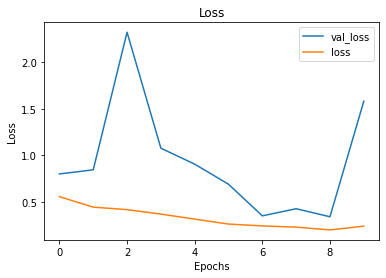

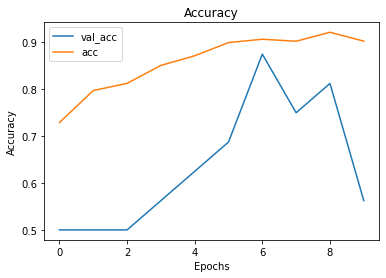

In [19]:
visualize_training_results_dense(results_1)

In [20]:
results_train = model_1.evaluate(train_img, train_labels)
results_train

163/163 [==============================] - 1s 7ms/step - loss: 0.4838 - accuracy: 0.8125


[0.4837769567966461, 0.8125]

In [21]:
results_test = model_1.evaluate(val_img, val_labels)
results_test

1/1 [==============================] - 0s 994us/step - loss: 1.5825 - accuracy: 0.5625


[1.582468032836914, 0.5625]

# model 2: CNN

In [22]:
#initialize a sequential model 
model_2 = models.Sequential()

#add 2 convolutional layers with pooling
model_2.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(128 , 128,  3)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(32, (3,3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))


model_2.add(layers.Flatten())
model_2.add(layers.Dense(1, activation='sigmoid'))

In [23]:
model_2.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 28801     
Total params: 49,057
Trainable params: 49,057
Non-trainable params: 0
__________________________________________________

In [27]:
"""Function to plot the loss function"""
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [25]:
results_2 = model_2.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_data=(val_images, val_labels))

Epoch 1/10
53/53 [==============================] - 81s 2s/step - loss: 0.5524 - acc: 0.7360 - val_loss: 0.8617 - val_acc: 0.5000
Epoch 2/10
53/53 [==============================] - 80s 2s/step - loss: 0.4704 - acc: 0.7962 - val_loss: 0.8414 - val_acc: 0.5625
Epoch 3/10
53/53 [==============================] - 80s 2s/step - loss: 0.4056 - acc: 0.8296 - val_loss: 0.4899 - val_acc: 0.6875
Epoch 4/10
53/53 [==============================] - 83s 2s/step - loss: 0.3265 - acc: 0.8629 - val_loss: 0.6567 - val_acc: 0.6250
Epoch 5/10
53/53 [==============================] - 90s 2s/step - loss: 0.2996 - acc: 0.8840 - val_loss: 0.8679 - val_acc: 0.6250
Epoch 6/10
53/53 [==============================] - 84s 2s/step - loss: 0.2358 - acc: 0.9039 - val_loss: 0.4548 - val_acc: 0.8125
Epoch 7/10
53/53 [==============================] - 85s 2s/step - loss: 0.1994 - acc: 0.9208 - val_loss: 2.7988 - val_acc: 0.5000
Epoch 8/10
53/53 [==============================] - 86s 2s/step - loss: 0.2100 - acc: 0.91

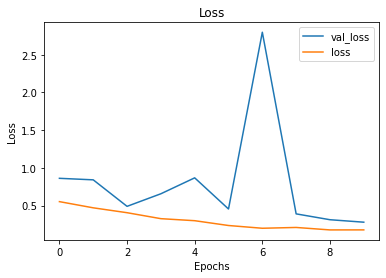

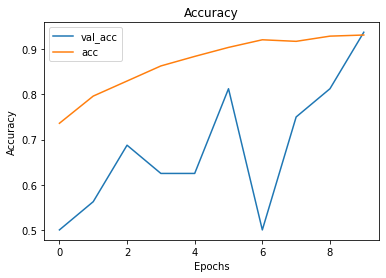

In [28]:
#visualizing loss and accuracy for the cnn model
visualize_training_results(results_2)

In [29]:
#evaluating cnn
results_train = model_2.evaluate(train_images, train_labels)
results_train

163/163 [==============================] - 22s 132ms/step - loss: 0.1954 - acc: 0.9243


[0.19536364078521729, 0.9242714643478394]

In [30]:
results_test = model_2.evaluate(val_images, val_labels)
results_test

1/1 [==============================] - 0s 0s/step - loss: 0.2798 - acc: 0.9375


[0.2797941565513611, 0.9375]

# Tuning CNN

##  Model 3 - CNN with Regularization and Dropout

## Dropout

In [31]:
model_3_1 = models.Sequential()
model_3_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))  # Dropout layer with a rate of 0.25

model_3_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))

model_3_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3_1.add(layers.MaxPooling2D((2, 2)))
model_3_1.add(layers.Dropout(0.25))

model_3_1.add(layers.Flatten())
model_3_1.add(layers.Dense(64, activation='relu'))
model_3_1.add(layers.Dense(1, activation='sigmoid'))


In [32]:
model_3_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
results_3_1 = model_3_1.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 [==============================] - 84s 516ms/step - loss: 0.3555 - accuracy: 0.8455 - val_loss: 0.5598 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 83s 509ms/step - loss: 0.1383 - accuracy: 0.9444 - val_loss: 0.5329 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 82s 501ms/step - loss: 0.1101 - accuracy: 0.9594 - val_loss: 0.2247 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 87s 536ms/step - loss: 0.0823 - accuracy: 0.9718 - val_loss: 0.4371 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 82s 504ms/step - loss: 0.0821 - accuracy: 0.9697 - val_loss: 0.3859 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 82s 502ms/step - loss: 0.0772 - accuracy: 0.9734 - val_loss: 0.2768 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 83s 506ms/step - loss: 0.0727 - accuracy: 0.9743 - val_loss: 0.1939 - val_ac

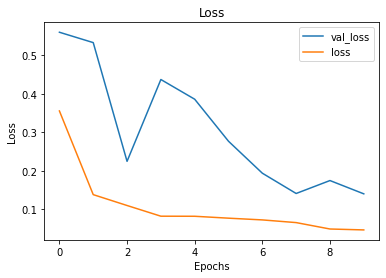

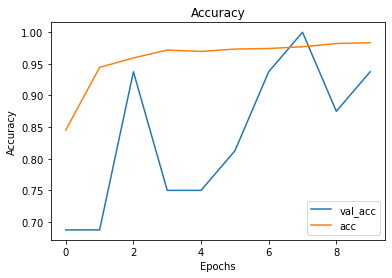

In [37]:
visualize_training_results_dense(results_3_1)

In [38]:
#evaluating 
results_train = model_3_1.evaluate(train_images, train_labels)
results_train

163/163 [==============================] - 20s 125ms/step - loss: 0.0319 - accuracy: 0.9875


[0.03190586343407631, 0.9875383377075195]

In [39]:
results_test = model_3_1.evaluate(val_images, val_labels)
results_test

1/1 [==============================] - 0s 0s/step - loss: 0.1403 - accuracy: 0.9375


[0.14031532406806946, 0.9375]

##  Dropout and L2 Regularization

In [43]:
model_3_2 = models.Sequential()
model_3_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_3_2.add(layers.MaxPooling2D((2, 2)))
model_3_2.add(layers.Dropout(0.25))  # Dropout layer with a rate of 0.25

# L2 regularization with a factor of 0.01
model_3_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3_2.add(layers.MaxPooling2D((2, 2)))
model_3_2.add(layers.Dropout(0.25))

# L2 regularization with a factor of 0.01
model_3_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3_2.add(layers.MaxPooling2D((2, 2)))
model_3_2.add(layers.Dropout(0.25))

model_3_2.add(layers.Flatten())
model_3_2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3_2.add(layers.Dense(1, activation='sigmoid'))


In [44]:
model_3_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
results_3_2 = model_3_2.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 [==============================] - 84s 514ms/step - loss: 1.1520 - accuracy: 0.7742 - val_loss: 1.2116 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 83s 508ms/step - loss: 0.3859 - accuracy: 0.9020 - val_loss: 1.0781 - val_accuracy: 0.5625
Epoch 3/10
163/163 [==============================] - 82s 503ms/step - loss: 0.2986 - accuracy: 0.9170 - val_loss: 0.5853 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 83s 510ms/step - loss: 0.2679 - accuracy: 0.9247 - val_loss: 0.8018 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 82s 504ms/step - loss: 0.2702 - accuracy: 0.9231 - val_loss: 0.9614 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 82s 503ms/step - loss: 0.2341 - accuracy: 0.9348 - val_loss: 0.7578 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 85s 519ms/step - loss: 0.2426 - accuracy: 0.9319 - val_loss: 0.8313 - val_ac

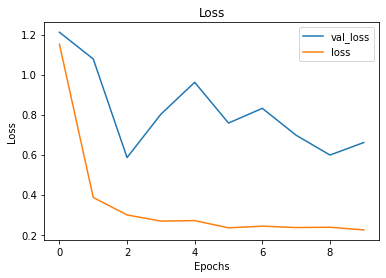

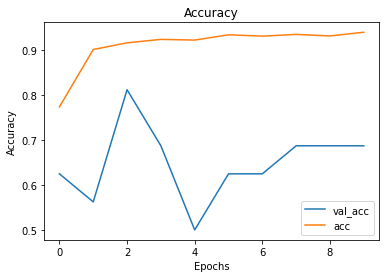

In [47]:
visualize_training_results_dense(results_3_2)

In [49]:
#evaluating 
results_train = model_3_2.evaluate(train_images, train_labels)
results_train

163/163 [==============================] - 21s 127ms/step - loss: 0.1883 - accuracy: 0.9536


[0.18830116093158722, 0.9536042809486389]

In [48]:
results_test = model_3_2.evaluate(val_images, val_labels)
results_test

1/1 [==============================] - 0s 0s/step - loss: 0.6604 - accuracy: 0.6875


[0.6604235768318176, 0.6875]

## Model 4 - CNN with Architecture modifications

##  Adding More  Layers

we've modified the architecture of the model by adding more convolutional layers and increasing the number of filters in each layer. Additionally, we've introduced two additional dense layers after the flattening layer.

In [50]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))


model_4.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(512, activation='relu'))
model_4.add(layers.Dense(256, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [51]:
model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [52]:
results_4 = model_4.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 [==============================] - 91s 558ms/step - loss: 0.4033 - accuracy: 0.8230 - val_loss: 0.8321 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 89s 546ms/step - loss: 0.1486 - accuracy: 0.9459 - val_loss: 0.3737 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 89s 548ms/step - loss: 0.0904 - accuracy: 0.9670 - val_loss: 0.1501 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 90s 551ms/step - loss: 0.0865 - accuracy: 0.9668 - val_loss: 0.2917 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 89s 547ms/step - loss: 0.0649 - accuracy: 0.9780 - val_loss: 0.2749 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 89s 549ms/step - loss: 0.0484 - accuracy: 0.9826 - val_loss: 0.5168 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 116s 712ms/step - loss: 0.0418 - accuracy: 0.9837 - val_loss: 0.1413 - val_a

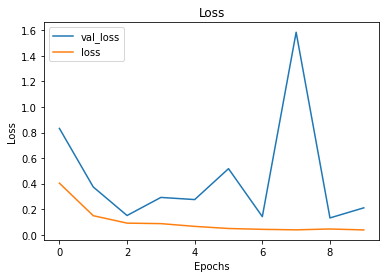

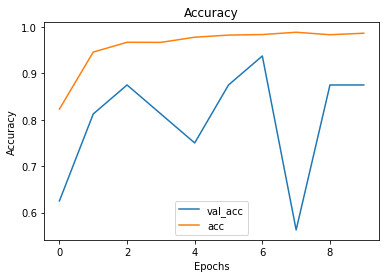

In [53]:
visualize_training_results_dense(results_4)

In [54]:
#evaluating 
results_train = model_4.evaluate(train_images, train_labels)
results_train

163/163 [==============================] - 44s 272ms/step - loss: 0.0159 - accuracy: 0.9950


[0.015929192304611206, 0.9950153231620789]

In [55]:
results_test = model_4.evaluate(val_images, val_labels)
results_test

1/1 [==============================] - 0s 10ms/step - loss: 0.2101 - accuracy: 0.8750


[0.2100926637649536, 0.875]

## More Layers, Regularization and Dropout

In [59]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.25))  # Dropout layer with a rate of 0.25

# L1 and L2 regularization with a factor of 0.01
model_5.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.25))

# L1 and L2 regularization with a factor of 0.01
model_5.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.25))

# L1 and L2 regularization with a factor of 0.01
model_5.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.25))

model_5.add(layers.Flatten())
model_5.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model_5.add(layers.Dense(1, activation='sigmoid'))

model_5.add(layers.Flatten())
model_5.add(layers.Dense(128, activation='relu'))
model_5.add(layers.Dense(256, activation='relu'))
model_5.add(layers.Dense(1, activation='sigmoid'))


In [60]:
model_5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [61]:
results_5 = model_5.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 [==============================] - 113s 696ms/step - loss: 14.0998 - accuracy: 0.7372 - val_loss: 1.2816 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 112s 686ms/step - loss: 1.0172 - accuracy: 0.7429 - val_loss: 1.2724 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 113s 695ms/step - loss: 1.0081 - accuracy: 0.7429 - val_loss: 1.2750 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 112s 689ms/step - loss: 1.0052 - accuracy: 0.7429 - val_loss: 1.2397 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 112s 688ms/step - loss: 1.0015 - accuracy: 0.7429 - val_loss: 1.2804 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 119s 729ms/step - loss: 0.9973 - accuracy: 0.7429 - val_loss: 1.2701 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 112s 689ms/step - loss: 0.9975 - accuracy: 0.7429 - val_loss: 1.2429 

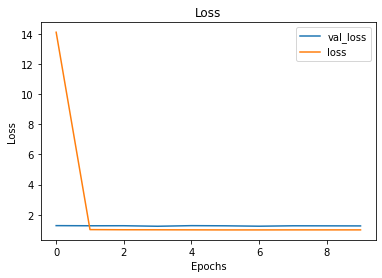

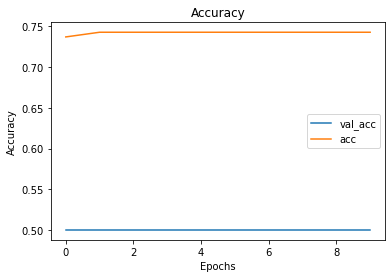

In [63]:
visualize_training_results_dense(results_5)

In [64]:
#evaluating 
results_train = model_5.evaluate(train_images, train_labels)
results_train

163/163 [==============================] - 29s 180ms/step - loss: 0.9965 - accuracy: 0.7429


[0.9965029358863831, 0.7429064512252808]

In [65]:
results_test = model_5.evaluate(val_images, val_labels)
results_test

1/1 [==============================] - 0s 0s/step - loss: 1.2629 - accuracy: 0.5000


[1.262891411781311, 0.5]

## Model 6 - CNN with Transfer Learning

## VGG19

In [66]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))

In [67]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [68]:
model_6 = models.Sequential()
model_6.add(cnn_base)
model_6.add(layers.Flatten())
model_6.add(layers.Dense(132, activation='relu'))
model_6.add(layers.Dense(1, activation='sigmoid'))

In [69]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_6.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model_6.trainable_weights))

vgg19 True
flatten_9 True
dense_23 True
dense_24 True
36


In [70]:
cnn_base.trainable = False

In [71]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_6.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(model_6.trainable_weights))

vgg19 False
flatten_9 True
dense_23 True
dense_24 True
4


In [72]:
model_6.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [73]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Resize the train_images and val_images to (64, 64)
train_images_resized = np.array([image.smart_resize(img, (64, 64)) for img in train_images])
val_images_resized = np.array([image.smart_resize(img, (64, 64)) for img in val_images])

# Train the model with the resized images
results_6 = model_6.fit(train_images_resized,
                        train_labels,
                        epochs=10,
                        batch_size= 32,
                        validation_data=(val_images_resized, val_labels))


Epoch 1/10
163/163 [==============================] - 227s 1s/step - loss: 0.4529 - acc: 0.7780 - val_loss: 0.5536 - val_acc: 0.6875
Epoch 2/10
163/163 [==============================] - 232s 1s/step - loss: 0.3074 - acc: 0.8790 - val_loss: 0.4897 - val_acc: 0.6875
Epoch 3/10
163/163 [==============================] - 226s 1s/step - loss: 0.2532 - acc: 0.9007 - val_loss: 0.4578 - val_acc: 0.6250
Epoch 4/10
163/163 [==============================] - 224s 1s/step - loss: 0.2234 - acc: 0.9132 - val_loss: 0.4476 - val_acc: 0.7500
Epoch 5/10
163/163 [==============================] - 225s 1s/step - loss: 0.2039 - acc: 0.9214 - val_loss: 0.4158 - val_acc: 0.7500
Epoch 6/10
163/163 [==============================] - 224s 1s/step - loss: 0.1888 - acc: 0.9302 - val_loss: 0.3913 - val_acc: 0.7500
Epoch 7/10
163/163 [==============================] - 224s 1s/step - loss: 0.1777 - acc: 0.9362 - val_loss: 0.4263 - val_acc: 0.8125
Epoch 8/10
163/163 [==============================] - 224s 1s/step - 

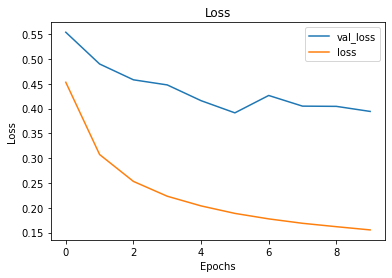

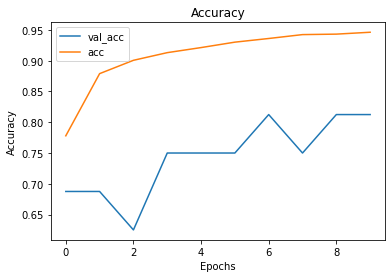

In [74]:
visualize_training_results(results_6)

In [75]:
#evaluating 
results_train = model_6.evaluate(train_images_resized, train_labels)
results_train

163/163 [==============================] - 237s 1s/step - loss: 0.1518 - acc: 0.9480


[0.15183217823505402, 0.94804447889328]

In [76]:
results_test = model_6.evaluate(val_images_resized, val_labels)
results_test

1/1 [==============================] - 0s 4ms/step - loss: 0.3942 - acc: 0.8125


[0.39415282011032104, 0.8125]

## Model Evaluation

In [91]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_2.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 4s 217ms/step - loss: 0.3740 - acc: 0.8317
Test Loss: 0.37402406334877014
Test Accuracy: 0.8317307829856873


In [92]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_3_1.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 4s 207ms/step - loss: 1.0687 - accuracy: 0.7853
Test Loss: 1.0686529874801636
Test Accuracy: 0.7852563858032227


In [93]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_3_2.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 4s 207ms/step - loss: 0.6293 - accuracy: 0.7885
Test Loss: 0.6292523741722107
Test Accuracy: 0.7884615659713745


In [94]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_4.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 5s 248ms/step - loss: 1.1343 - accuracy: 0.7869
Test Loss: 1.1343283653259277
Test Accuracy: 0.7868589758872986


In [95]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_5.evaluate(test_images, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 3s 168ms/step - loss: 1.1258 - accuracy: 0.6250
Test Loss: 1.1258068084716797
Test Accuracy: 0.625


In [96]:

test_images_resized = np.array([image.smart_resize(img, (64, 64)) for img in test_images])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_6.evaluate(test_images_resized, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


20/20 [==============================] - 29s 1s/step - loss: 0.5205 - acc: 0.7628
Test Loss: 0.5204616189002991
Test Accuracy: 0.7628205418586731
